In [1]:
import cupy as cp
import cupyx
import scanpy as sc
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import random
import pandas as pd
import voyagerpy as vp
import geopandas as gpd
from collections import OrderedDict
import pickle

In [2]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072824"
grid = sc.read_h5ad(os.path.join(pathout, "grid_save.h5ad"))
file_path = os.path.join(pathout, "grid_uns_mtracies.pkl")

if os.path.getsize(file_path) > 0:
    with open(file_path, 'rb') as buff:
        grid_uns_mtracies = pickle.load(buff)
else:
    print("File is empty. Cannot load data.")
    grid_uns_mtracies = None
grid.uns = {}
grid.uns['cluster'] = pd.read_csv(os.path.join(pathout, "cluster.csv"))
grid.uns['grid_counts'] = grid_uns_mtracies['grid_counts']
grid.uns['grid_xedges'] = grid_uns_mtracies['grid_xedges']
grid.uns['grid_yedges'] = grid_uns_mtracies['grid_yedges']
grid.uns['lrfeatures'] = pd.read_csv(os.path.join(pathout, "lrfeatures.csv"))
grid.uns['lr_summary'] = pd.read_csv(os.path.join(pathout, "lr_summary.csv"))
sparse_matrix = grid.X
row_sums = sparse_matrix.sum(axis=1)
grid.obs['n_counts'] = np.array(row_sums).flatten()
grid.layers['counts'] = grid.X.copy()
sc.pp.normalize_total(grid)
sc.pp.log1p(grid)
grid.layers['log'] = grid.X.copy()
sc.pp.scale(grid, max_value=10)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy-voyagerpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [3]:
scale = 1
visium_spots = gpd.GeoSeries.from_xy(grid.obsm['spatial'][:,0], grid.obsm['spatial'][:,1]).scale(scale, scale, origin=(0, 0))
_ = vp.spatial.set_geometry(grid, geom="spot_poly", values=visium_spots)
grid.uns['config'] = OrderedDict()
grid.uns["config"]["secondary_var_names"] = grid.var_names

In [4]:
sc.pp.pca(grid, n_comps=15)

In [5]:
sc.pp.neighbors(
    grid,
    n_neighbors=25,
    n_pcs=15,
    use_rep='X_pca',
    knn=True,
    random_state=29403943,
    method='umap', # one of umap, gauss, rapids
    metric='cosine', # many metrics available,
    key_added='knn'
)

In [6]:
dist = grid.obsp['knn_distances'].copy()
dist.data = 1 / dist.data

# row normalize the matrix, this makes the matrix dense.
dist /= dist.sum(axis=1)

# convert dist back to sparse matrix
from scipy.sparse import csr_matrix
grid.obsp["knn_weights"] = csr_matrix(dist)

del dist

knn_graph = "knn_weights"

# adata.obsp["knn_connectivities"] represent the edges, while adata.opsp["knn_weights"] represent the weights
grid.obsp["knn_connectivities"] = (grid.obsp[knn_graph] > 0).astype(int)
vp.spatial.set_default_graph(grid, knn_graph)
vp.spatial.to_spatial_weights(grid, graph_name=knn_graph)

AnnData object with n_obs × n_vars = 35389 × 1500
    obs: 'imagecol', 'imagerow', 'n_cells', 'cluster', 'n_counts'
    var: 'mean', 'std'
    uns: 'cluster', 'grid_counts', 'grid_xedges', 'grid_yedges', 'lrfeatures', 'lr_summary', 'log1p', 'config', 'pca', 'knn', 'spatial'
    obsm: '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'spatial', 'spot_neigh_bcs', 'spot_neighbours', 'geometry', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'knn_distances', 'knn_connectivities', 'knn_weights'

In [7]:
qc_features = ["n_counts"]

In [8]:
morans = vp.spatial.moran(grid, qc_features, graph_name=knn_graph)
grid.uns['spatial']['moran'][knn_graph].loc[qc_features, ["I"]]

,I
n_counts,0.011651


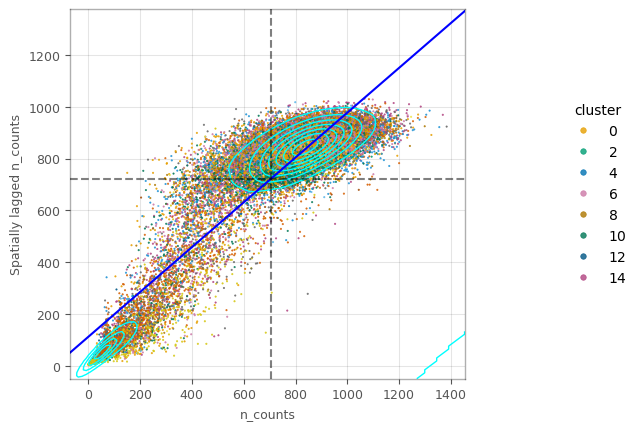

In [9]:
vp.spatial.compute_spatial_lag(
    grid,
    qc_features,
    graph_name=knn_graph,
    inplace=True
)

ax = vp.plt.moran_plot(grid, feature='n_counts', color_by='cluster', alpha=0.8,s =1)

In [20]:
_ = vp.spatial.local_moran(grid, qc_features, graph_name=knn_graph)

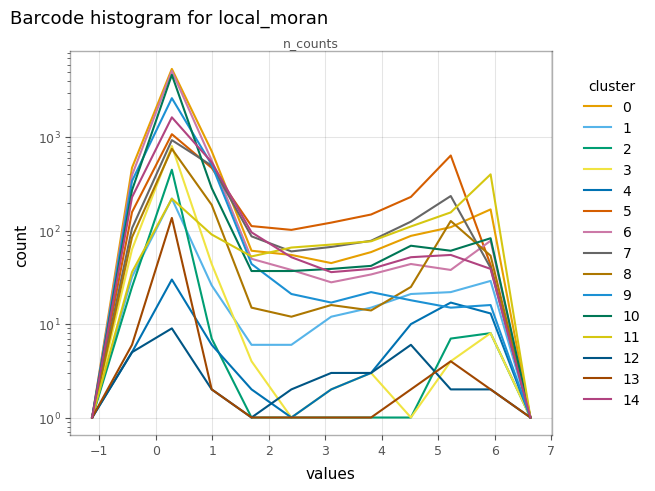

In [23]:
axs = vp.plt.plot_barcode_histogram(
    grid,
    qc_features,
    obsm="local_moran",
    color_by='cluster',
    log=True,
    histtype='line',
    bins=10,
)